In [42]:
import re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
sys.path.append("/Users/santy/odrive/Google Drive/github projects/questaal-reader/")
from questaal_reader import get_bands
from pymatgen.electronic_structure.plotter import BSPlotter as bp

In [43]:
# extracting vals
import numpy as np
import re
def save_wave(nk1=6,nk2=6,nk3=6,v=10,c=5,n=200):
    def extract_nums(text):
        numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
        rx = re.compile(numeric_const_pattern, re.VERBOSE)
        num=[float(i) for i in rx.findall(text)]
        try:
            return num[0]+1j*num[1]
        except:None
    def get_eig_fromquestaal(eig_fname):
        eigenvecs=[]
        cnt=0
        with open(eig_fname) as topo_file:
                for line in topo_file:
                    if cnt==nk1*nk2*nk3*v*c*n:
                        break
                    if "val" not in line:
                        eigenvecs.append(extract_nums(line))
                        cnt+=1

    vals=get_eig_fromquestaal("Eigenvecs_bse")
    vals=np.array(vals).reshape(-1,nk1*nk2*nk3*v*c)
    np.save("wave_data.npy",vals[:n])
# save_wave(nk1=6,nk2=6,nk3=6,v=10,c=5,n=200)

In [44]:
import numba

def extract_nums(text):
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    num=[float(i) for i in rx.findall(text)]
    try:
        return num[0]+1j*num[1]
    except:None

def get_eig_fromquestaal(eig_fname):
    eigenvecs=[]
    with open(eig_fname) as topo_file:
            for line in topo_file:
                if "val" not in line:
                    eigenvecs.append(extract_nums(line))
    return eigenvecs
def get_kpts(qpts_fname="data/lif/QBZ"):
    kpts=[]
    with open(qpts_fname) as topo_file:
        for line in topo_file:
            x=line.split()
            if len(x)>1:
                kpts.append([extract_nums(j) for j in x])
    kpts=np.real(np.array(kpts))
    return kpts

def get_wave_kpts(fname="data/lif/wave.npy",qpts_fname="data/lif/QBZ",v=4,c=4,ignore=False):
    kpts=get_kpts(qpts_fname)
    # return np.flip(np.load(fname,allow_pickle=True)[1:].reshape(-1,len(kpts),v,c),axis=2).astype(np.complex),kpts
    if ignore:
        return np.load(fname,allow_pickle=True)[1:].reshape(-1,len(kpts),v,c).astype(np.complex),kpts
    else:
        return np.load(fname,allow_pickle=True).reshape(-1,len(kpts),v,c).astype(np.complex),kpts

def get_vals(kpts_calc,n=0,v=0,c=0):
    from scipy.interpolate import griddata
    vals=griddata(kpts, sq(wave[n][:,v,c]),kpts_calc, method='linear')
    return vals

sq = lambda a: np.real(a*a.conj())

In [ ]:

def get_me_s(kpts_calc,v=None,c=None,vmax=4,cmax=4,n=0):
    s=[]
    if v==None:
        for i in range(vmax):
            s.append(get_vals(kpts_calc,n=n,v=i,c=c))
        return np.array(s).sum(axis=0)
    if c==None:
        for i in range(cmax):
            s.append(get_vals(kpts_calc,n=n,v=v,c=i))
        return np.array(s).sum(axis=0)
def get_exciton_weight(kpts_calc,nbnd,fermi_bnd=4,vmax=4,cmax=4,n=0):
    if nbnd>=vmax+cmax:
        return None
    if nbnd<fermi_bnd:
        return get_me_s(kpts_calc,v=nbnd,c=None,vmax=vmax,cmax=cmax,n=n)
    else:
        return get_me_s(kpts_calc,v=None,c=nbnd-fermi_bnd,vmax=vmax,cmax=cmax,n=n)
def get_exciton_weight(kpts_calc,nbnd,fermi_bnd=4,vmax=4,cmax=4,n=0):
    if fermi_bnd-vmax<nbnd<=fermi_bnd:
        bnd_index= nbnd-(fermi_bnd-vmax)-1
        return get_me_s(kpts_calc,v=bnd_index,c=None,vmax=vmax,cmax=cmax,n=n)
    elif fermi_bnd<nbnd<=fermi_bnd+cmax:
         bnd_index= nbnd-fermi_bnd-1
         return get_me_s(kpts_calc,v=None,c=bnd_index,vmax=vmax,cmax=cmax,n=n)
    else: return None

# For LiF

In [74]:
wave,kpts=get_wave_kpts(ignore=True)

In [75]:
bands=get_bands("data/lif/bnds.temp",coords_are_cartesian=False)
bp_plot=bp(bands).bs_plot_data()

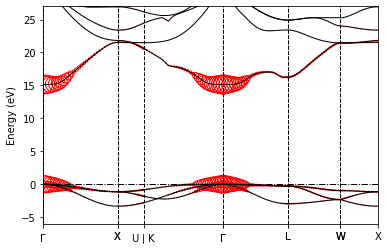

In [83]:
fig,ax=plt.subplots()
d=bp_plot['distances']
d=np.array(d).flatten()
e=bp_plot['energy']['1']
kpts_calc=[i.frac_coords.tolist() for i in bands.kpoints]
for nbnd in range(19):
    energy=np.array(e)[:,nbnd,:].flatten()
    ax.plot(d,energy,c="k",lw=1)
    s=get_exciton_weight(kpts_calc,nbnd,fermi_bnd=3,vmax=4,cmax=4,n=0)
    if s is not None:
        ax.scatter(d,energy,s=s*1e3,facecolor="none",alpha=1,edgecolor="r")
for j,i in enumerate(bp_plot['ticks']["distance"]):
        ax.axvline(i,c="k",ls="--",lw=1)
for j,i in enumerate ([ax]):
    fs=10
    i.tick_params(axis='y',labelsize=fs)
    i.set_xticks(bp_plot['ticks']["distance"])
    i.set_xticklabels(bp_plot['ticks']["label"],fontsize=fs)
    i.axhline(0,ls="-.",c="k",lw=1)
    i.set_ylim(-6,27)
    i.autoscale(enable=True, axis='x', tight=True)
    i.set_ylabel("Energy (eV)",fontsize=fs)
plt.savefig("figs/LIF-bands.png",dpi=300)

# For CoO2

In [48]:
# wave,kpts=get_wave_kpts(fname="data/coo2/wave_usable.npy",qpts_fname="data/coo2/QBZ",v=7,c=5)
wave,kpts=get_wave_kpts(fname="data/coo2/wave_data.npy",qpts_fname="data/coo2/QBZ",v=10,c=5)

In [49]:
bands=get_bands("data/coo2/bnds.temp",coords_are_cartesian=False)
bp_plot=bp(bands).bs_plot_data()

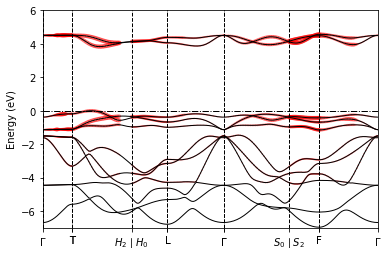

In [52]:
fig,ax=plt.subplots()
d=bp_plot['distances']
d=np.array(d).flatten()
e=bp_plot['energy']['1']
kpts_calc=[i.frac_coords.tolist() for i in bands.kpoints]
for nbnd in range(30):
    energy=np.array(e)[:,nbnd,:].flatten()
    ax.plot(d,energy,c="k",lw=1)
    s=get_exciton_weight(kpts_calc,nbnd,fermi_bnd=10,vmax=7,cmax=5,n=3)
    if s is not None:
        ax.scatter(d,energy,s=s*5e5,facecolor="none",alpha=.5,edgecolor="r",zorder=-10)
for j,i in enumerate(bp_plot['ticks']["distance"]):
        ax.axvline(i,c="k",ls="--",lw=1)
for j,i in enumerate ([ax]):
    fs=10
    i.tick_params(axis='y',labelsize=fs)
    i.set_xticks(bp_plot['ticks']["distance"])
    i.set_xticklabels(bp_plot['ticks']["label"],fontsize=fs)
    i.axhline(0,ls="-.",c="k",lw=1)
    i.set_ylim(-7,6)
    i.autoscale(enable=True, axis='x', tight=True)
    i.set_ylabel("Energy (eV)",fontsize=fs)
# plt.savefig("figs/Coo2-bands.png",dpi=300)

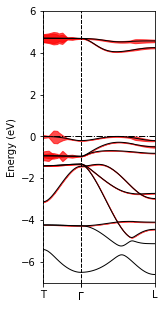

In [75]:
# wave,kpts=get_wave_kpts(fname="data/coo2/wave_usable.npy",qpts_fname="data/coo2/QBZ",v=7,c=5)
wave,kpts=get_wave_kpts(fname="data/coo2/wave_data.npy",qpts_fname="data/coo2/QBZ",v=10,c=5)
bands=get_bands("data/coo2/bands_small/bnds.temp",coords_are_cartesian=False)
bp_plot=bp(bands).bs_plot_data()
scale=1.5e4
fig,ax=plt.subplots(figsize=(2,5))
d=bp_plot['distances']
d=np.array(d).flatten()
e=bp_plot['energy']['1']
kpts_calc=[i.frac_coords.tolist() for i in bands.kpoints]
for nbnd in range(30):
    energy=np.array(e)[:,nbnd,:].flatten()
    ax.plot(d,energy,c="k",lw=1)
    s=get_exciton_weight(kpts_calc,nbnd,fermi_bnd=10,vmax=7,cmax=5,n=3)
    if s is not None:
        # ax.scatter(d,energy,s=s*1e6,facecolor="none",alpha=.5,edgecolor="r",zorder=-10)
        # ax.scatter(d,energy,s=s*1e6,facecolor="none",alpha=.5,edgecolor="r",zorder=-10)
        ax.fill_between(d,energy-s*scale,energy+s*scale,color="r",edgecolor="r",alpha=0.7)
for j,i in enumerate(bp_plot['ticks']["distance"]):
        ax.axvline(i,c="k",ls="--",lw=1)
for j,i in enumerate ([ax]):
    fs=10
    i.tick_params(axis='y',labelsize=fs)
    i.set_xticks(bp_plot['ticks']["distance"])
    i.set_xticklabels(bp_plot['ticks']["label"],fontsize=fs)
    i.axhline(0,ls="-.",c="k",lw=1)
    i.set_ylim(-7,6)
    i.autoscale(enable=True, axis='x', tight=True)
    i.set_ylabel("Energy (eV)",fontsize=fs)
# plt.savefig("figs/Coo2-bands.png",dpi=300)